# Market Basket Analysis on Amazon Book Reviews Using FP-Growth Algorithm
* Name Surname: Samet Cagan
* Matriculation: 985869
* Master in Data Science for Economics

# Install *requirements*

In [1]:
!pip install kaggle
!pip install spark-nlp
!pip install pyspark


# Install Dataset

In [2]:
import pandas as pd
import os
import zipfile

os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxx"


zip_path = "amazon-books-reviews.zip"
csv_path = os.path.join("data", "Books_rating.csv")

if not os.path.exists(csv_path):

    !kaggle datasets download -d mohamedbakhet/amazon-books-reviews
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("data")


# Initialize Spark

In [3]:


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, split, array_distinct
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.fpm import FPGrowth
from pyspark import SparkConf, SparkContext
import seaborn as sns
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("AmazonBookReviews_MarketBasket") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# read dataset by using spark

In [4]:
df = spark.read.csv("data/Books_rating.csv", header=True, inferSchema=True, escape='"')
#df_books_data = spark.read.csv("data/books_data.csv", header=True, inferSchema=True, escape='"')



In [5]:
## I did this if by doing this can we get unique titles, but after checking outputs, We would have more information to lose than to gain.
#df = df_rating.join(
#    df_books_data.select("Title", "infoLink", "publishedDate"),
#    on="Title",
#    how="left"
#)
##so we can skip this process. it would be unneccesarry..

# Data exploratation

In [6]:
from pyspark.sql.functions import countDistinct
df.select(countDistinct("Title").alias("n_unique_titles")).show()

+---------------+
|n_unique_titles|
+---------------+
|         212403|
+---------------+



In [7]:
df.createOrReplaceTempView("reviews")

spark.sql("""
    SELECT COUNT(DISTINCT User_id) AS n_unique_users
    FROM reviews
    WHERE User_id IS NOT NULL
""").show()


+--------------+
|n_unique_users|
+--------------+
|       1008972|
+--------------+



In [8]:
from pyspark.sql.functions import col, count

reviews_per_user = (
    df
    .filter(col("User_id").isNotNull())
    .groupBy("User_id")
    .agg(count("*").alias("n_reviews"))
    .orderBy(col("n_reviews").desc())
)

reviews_per_user.show(n=5, truncate=False)

+--------------+---------+
|User_id       |n_reviews|
+--------------+---------+
|A14OJS0VWMOSWO|5795     |
|AFVQZQ8PW0L   |3606     |
|A1D2C0WDCSHUWZ|3146     |
|AHD101501WCN1 |1995     |
|A1X8VZWTOG8IS6|1804     |
+--------------+---------+
only showing top 5 rows


In [9]:
review_cs = reviews_per_user.toPandas()
review_cs.n_reviews.describe()

,n_reviews
count,1.008972e+06
mean,2.416532e+00
std,1.213263e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,5.795000e+03


/tmp/ipython-input-657880803.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


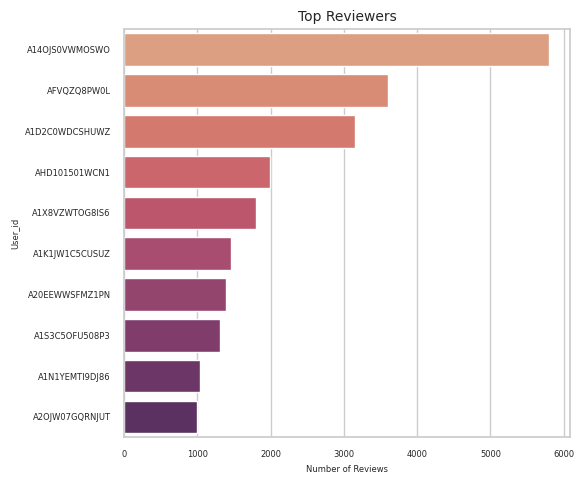

In [10]:
review_cs = review_cs.head(10)

sns.set_theme(style="whitegrid")

# Initialize the figure size
plt.figure(figsize=(6, 5))

# Create the Bar Plot
barplot = sns.barplot(
    x="n_reviews",
    y="User_id",
    data=review_cs,
    palette="flare"
)

# Add Labels and Title
plt.title("Top Reviewers", fontsize=10)
plt.xlabel("Number of Reviews", fontsize=6)
plt.ylabel("User_id", fontsize=6)

barplot.tick_params(axis='y', labelsize=6)
barplot.tick_params(axis='x', labelsize=6)

plt.tight_layout()
plt.show()


In [11]:
from pyspark.sql.functions import count

#group by title and then Count
book_counts = (
    df
    .filter(col("Title").isNotNull())
    .groupBy("Title")
    .count()
    .withColumnRenamed("count", "n_reviews")
    .orderBy(col("n_reviews").desc())
)


print("Statistics of Reviews per Book:")
book_counts.select("n_reviews").describe().show()


Statistics of Reviews per Book:
+-------+------------------+
|summary|         n_reviews|
+-------+------------------+
|  count|            212403|
|   mean|14.123115021915886|
| stddev|116.15642405363751|
|    min|                 1|
|    max|             22023|
+-------+------------------+



In [12]:
book_cs = book_counts.toPandas()
book_cs.n_reviews.describe()

,n_reviews
count,212403.000000
mean,14.123115
std,116.156424
min,1.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,22023.000000


In [13]:
top_books_pdf = book_cs.head(10)

/tmp/ipython-input-3256500945.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


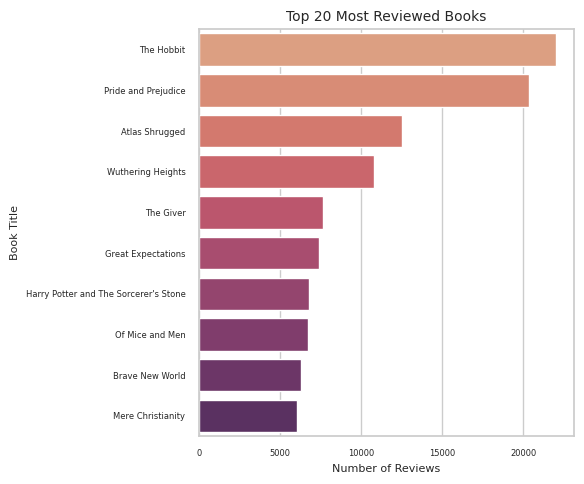

In [14]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(6, 5))

barplot = sns.barplot(
    x="n_reviews",
    y="Title",
    data=top_books_pdf,
    palette="flare"
)

plt.title("Top 20 Most Reviewed Books", fontsize=10)
plt.xlabel("Number of Reviews", fontsize=8)
plt.ylabel("Book Title", fontsize=8)
barplot.tick_params(axis='y', labelsize=6)
barplot.tick_params(axis='x', labelsize=6)
plt.tight_layout()
plt.show()

# REVIEW/TEXT handling-cleaning-filtering

> Add blockquote



In [15]:
from pyspark.sql.functions import col, lower, regexp_replace, trim
from pyspark.sql.functions import countDistinct

# to Filter null titles first
df_titles = df.filter(col("Title").isNotNull())

# to Lowercase
df_clean = df_titles.withColumn("Title_Clean", lower(col("Title")))

# to Remove Punctuation
df_clean = df_clean.withColumn("Title_Clean", regexp_replace(col("Title_Clean"), "[^a-z0-9\\s]", ""))

# to Remove Articles (a, an, the, or)
df_clean = df_clean.withColumn("Title_Clean", regexp_replace(col("Title_Clean"), "\\b(a|or|an|the)\\b", " "))

# to Fix multiple Whitespaces
df_clean = df_clean.withColumn("Title_Clean", trim(regexp_replace(col("Title_Clean"), "\\s+", " ")))



In [16]:



# count Unique Original Titles
unique_original_count = df_clean.select(countDistinct("Title")).collect()[0][0]

# count Unique Clean Titles
unique_clean_count = df_clean.select(countDistinct("Title_Clean")).collect()[0][0]

print(f"Original Unique Titles: {unique_original_count}")
print(f"Clean Unique Titles:  {unique_clean_count}")
print(f"removed: {unique_original_count - unique_clean_count}.")



Original Unique Titles: 212403
Clean Unique Titles:  205589
removed: 6814.


In [17]:
df_clean.columns

['Id',
 'Title',
 'Price',
 'User_id',
 'profileName',
 'review/helpfulness',
 'review/score',
 'review/time',
 'review/summary',
 'review/text',
 'Title_Clean']

In [18]:
df_clean.select("Title", "Title_Clean").distinct().show(5, truncate=30)

+------------------------------+------------------------------+
|                         Title|                   Title_Clean|
+------------------------------+------------------------------+
|A Dose of Sanity: Mind, Med...|dose of sanity mind medicin...|
|Learn to Play Golf in a Wee...| learn to play golf in weekend|
|         Paradise Kiss, Book 4|          paradise kiss book 4|
|Semi-Homemade Cooking: Quic...|semihomemade cooking quick ...|
|Principles and Parameters: ...|principles and parameters i...|
+------------------------------+------------------------------+
only showing top 5 rows


In [ ]:
from pyspark.sql.functions import col, collect_set, size


# group by User_id and collect all unique cleaned titles into an array called 'items'
user_baskets = (
    df_clean
    .filter(col("User_id").isNotNull())
    .groupBy("User_id")
    .agg(collect_set("Title_Clean").alias("items"))
)

# filter baskets to ensure the user has reviewed at least 2 unique books after cleaning
user_baskets_standardized = (
    user_baskets
    .filter(size(col("items")) >= 2)
)

print("Sample of Standardized Baskets for FP-Growth:")
user_baskets_standardized.show(5, truncate=False)

print(f"Total baskets ready for FP-Growth: {user_baskets_standardized.count()}")

Sample of Standardized Baskets for FP-Growth:
+---------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|User_id              |items                                                                                                                                                                                                                                                                             |
+---------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|A0015610VMNR0JC9XVL1 |[richest man in babylon, richest m



# MODEL



In [ ]:
from pyspark.ml.fpm import FPGrowth

fp_book = FPGrowth(
    itemsCol="items",
    minSupport=0.0005,
    minConfidence=0.05
)

model_book = fp_book.fit(user_baskets_standardized)

In [ ]:
model_book.associationRules.show(n=10, truncate=False)

In [ ]:
from pyspark.sql.functions import col, split, size

recommendations = (
    model_book.associationRules
    # simple 1-to-1 rules
    .filter(size(col("antecedent")) == 1)
    .filter(size(col("consequent")) == 1)

    # filter dublicates
    .filter((col("confidence") < 0.95) )

    # filter by title similarity
    .withColumn("ant_first", split(col("antecedent").getItem(0), " ").getItem(0))
    .withColumn("con_first", split(col("consequent").getItem(0), " ").getItem(0))
    .filter(col("ant_first") != col("con_first"))

    .orderBy("lift", ascending=False)
)

print(" Top 10 Book Recommendations")
recommendations.select("antecedent", "consequent", "confidence", "lift").show(25, truncate=False)

In [ ]:
from pyspark.sql.functions import col, split, size

# Start with the full set of rules
recommendations = (
    model_book.associationRules
    # simple 2-to-1 rules
    .filter(size(col("antecedent")) == 2)
    .filter(size(col("consequent")) == 1)
    .withColumn("ant_first", split(col("antecedent").getItem(0), " ").getItem(0))
    .withColumn("con_first", split(col("consequent").getItem(0), " ").getItem(0))
    .filter(col("ant_first") != col("con_first"))
    .orderBy("lift", ascending=False)
)

print("--- Top 10 'Real' Book Recommendations (Non-Duplicate) ---")
recommendations.select("antecedent", "consequent", "confidence", "lift").show(25, truncate=False)

In [ ]:
from pyspark.sql.functions import udf, col, size
from pyspark.sql.types import FloatType


def title_similarity(title_a, title_b):
    set_a = set(title_a.lower().split())
    set_b = set(title_b.lower().split())

    # Calculate Jaccard Similarity
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))

    if union == 0: return 0.0
    return intersection / union

similarity_udf = udf(title_similarity, FloatType())

print("Top Frequent Itemsets")

(
    model_book.freqItemsets
    .filter(size(col("items")) == 2)

    #Calculate the similarity between the two items in the set
    .withColumn(
        "similarity",
        similarity_udf(col("items").getItem(0), col("items").getItem(1))
    )
    .filter(col("similarity") < 0.50)

    #Sort by the frequency count ('freq')
    .orderBy("freq", ascending=False)
    .show(50, truncate=False)
)